In [1]:
from yahoo_finance import Share
from datetime import datetime, date
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pickle

pd.set_option('display.max_columns', 50)


def getStock(start_date, id):
    """
    datetime format example: '2016-01-28'
    """
    stock = Share(str(id)+'.TW')
    today = date.today() #todays date
    data = stock.get_historical(start_date, str(today))
    return data

In [2]:
taiwan50_symbols = [1101, 1102, 1216, 1301, 1303, 1326, 1402, 1722, 2002, 2105, 2201, 2207, 2301, 2303, 2308, 2311, 2317,
           2324, 2325, 2330, 2347, 2353, 2354, 2357, 2382, 2409, 2412, 2454, 2474, 2498, 2801, 2880, 2881, 2882, 2883,
           2885, 2886, 2890, 2891, 2892, 2912, 3008, 3045, 3231, 3481, 3673, 3697, 4904, 5880, 6505]

In [3]:
len(taiwan50_symbols)

50

In [4]:
def create_dataframe(data):
    # Create df from data
    df = pd.DataFrame(data)
    # Set date as index
    df = df.set_index('Date')
    # Convert index str to datetime object
    df.index = pd.to_datetime(df.index)
    
    # Create dfMain for reordering data
    start_date = '2000-01-01'
    end_date = '2017-03-03'
    dates = pd.date_range(start_date, end_date)
    dfMain = pd.DataFrame(index=dates)
    dfMain = dfMain.join(df)
    dfMain.dropna(inplace=True)
    
    # Convert str values to numeric
    dfMain = dfMain.convert_objects(convert_numeric=True)
    
    # Drop suspension dates
    dfMain.drop(dfMain[dfMain['Volume'] == 0].index, inplace=True)
    
    # Drop data anomoly based on volume
    mean = dfMain['Volume'].mean()
    std = dfMain['Volume'].std()
    dfMain.drop(dfMain[dfMain['Volume'] - mean > 5 * std].index, inplace=True)
    # Drop Symbol Column
    del dfMain['Symbol']
    
    return dfMain

In [152]:
# # Download and create Taiwan 50 dataframes
# taiwan50 = {}

# for symbol in taiwan50_symbols:
#     try:
#         data_temp = getStock('2000-01-01', symbol)
#     except (KeyboardInterrupt, SystemExit):
#         raise
#     except:
#         print("Error symbol: {}".format(symbol))
#     else:
#         taiwan50[symbol] = create_dataframe(data_temp)

/home/calvinjku/anaconda3/envs/chimp/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Error symbol: 2409
Error symbol: 2412
Error symbol: 2454
Error symbol: 2498
Error symbol: 2880
Error symbol: 2881
Error symbol: 2883
Error symbol: 2891
Error symbol: 2892
Error symbol: 3008
Error symbol: 3045
Error symbol: 3231
Error symbol: 3481
Error symbol: 3673
Error symbol: 3697
Error symbol: 4904
Error symbol: 5880
Error symbol: 6505


In [153]:
# len(taiwan50)

32

In [157]:
# print(taiwan50.keys())

dict_keys([1216, 2882, 2308, 2885, 2886, 2311, 2890, 1101, 1102, 2317, 2002, 2324, 2325, 1303, 2201, 2330, 1402, 2207, 2912, 2801, 2474, 2347, 1326, 2353, 2354, 2382, 2357, 2105, 1722, 2303, 2301, 1301])


In [156]:
# for key in taiwan50:
#     taiwan50[key].to_csv('./data/' + str(key) + '.csv')

In [28]:
import glob

taiwan50 = {}

taiwan50_filenames = glob.glob('./data/*.csv')

for filename in taiwan50_filenames:
    taiwan50[int(filename[-8:-4])] = pd.DataFrame.from_csv(filename)

In [29]:
good_data_symbols = [1216, 2308, 2311, 2890, 1101, 1102, 2317, 2002, 2324, 2325, 1303, 2201, 2330, 1402, 2207, 
                     2912, 2801, 2474, 2347, 1326, 2353, 2354, 2382, 2357, 1722, 2303, 2301, 1301]

In [30]:
stocks = {key: taiwan50[key] for key in good_data_symbols}

In [31]:
def adjust_prices(dfMain):
    # Adjust Open, High, Low, Volume
    dfMain['Adj Factor'] = dfMain['Adj_Close'] / dfMain['Close']

    dfMain['Open'] = dfMain['Open'] * dfMain['Adj Factor']
    dfMain['High'] = dfMain['High'] * dfMain['Adj Factor']
    dfMain['Low'] = dfMain['Low'] * dfMain['Adj Factor']
    dfMain['Volume'] = dfMain['Volume'] / dfMain['Adj Factor']

    dfMain.drop(['Adj Factor'], axis=1, inplace=True)
    
    return dfMain

In [32]:
def add_past_prices(dfMain):
    # Price Engineering
    # Get opens
    period_list = [1, 2, 3, 4, 5, 10, 21, 63, 100]
    for x in period_list:
        dfMain['-' + str(x) + 'd_Open'] = dfMain['Open'].shift(x)

    # Get adjCloses
    period_list = range(1, 5 + 1)
    for x in period_list:
        dfMain['-' + str(x) + 'd_adjClose'] = dfMain['Adj_Close'].shift(x)

    # Get highs
    period_list1 = range(1, 5 + 1)
    for x in period_list1:
        dfMain['-' + str(x) + 'd_High'] = dfMain['High'].shift(x)

    period_list2 = [10, 21, 63, 100]
    for x in period_list2:
        dfMain[str(x) + 'd_High'] = dfMain['High'].shift().rolling(window=x).max()

    # Get lows
    period_list1 = range(1, 5 + 1)
    for x in period_list1:
        dfMain['-' + str(x) + 'd_Low'] = dfMain['Low'].shift(x)

    period_list2 = [10, 21, 63, 100]
    for x in period_list2:
        dfMain[str(x) + 'd_Low'] = dfMain['High'].shift().rolling(window=x).min()
    
    return dfMain

In [33]:
def get_bases(dfMain):
    # Get Volume Bases
    dfMain['100d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=100).mean() * 1.5
    dfMain['100d_Max_Vol'] = dfMain['Volume'].shift().rolling(window=100).max()

    # Get Spread Bases
    dfMain['Abs_Spread'] = np.abs(dfMain['Adj_Close'] - dfMain['Open'])
    dfMain['Abs_Spread_Shift1'] = dfMain['Abs_Spread'].shift()
    dfMain['100d_Avg_Spread'] = dfMain['Abs_Spread_Shift1'].rolling(window=100).mean() * 1.5
    dfMain['100d_Max_Spread'] = dfMain['100d_High'] - dfMain['100d_Low']

    dfMain.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)
    
    return dfMain

In [34]:
def relative_transform(num):
    if 0 <= num < 0.25:
        return 1
    elif 0.25 <= num < 0.5:
        return 2
    elif 0.5 <= num < 0.75:
        return 3
    elif 0.75 <= num < 1:
        return 4
    elif 1 <= num:
        return 5
    elif -0.25 <= num < 0:
        return -1
    elif -0.5 <= num < -0.25:
        return -2
    elif -0.75 <= num < -0.5:
        return -3
    elif -1 <= num < -0.75:
        return -4
    elif num < -1:
        return -5
    else:
        num

In [35]:
def get_volumes(dfMain):
    # Volume Engineering
    # Get volumes
    period_list = range(1, 5 + 1)
    for x in period_list:
        dfMain['-' + str(x) + 'd_Vol'] = dfMain['Volume'].shift(x)

    # Get avg. volumes
    period_list = [10, 21, 63]
    for x in period_list:
        dfMain[str(x) + 'd_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=x).mean()

    # Get relative volumes 1
    period_list = range(1, 5 + 1)
    for x in period_list:
        dfMain['-' + str(x) + 'd_Vol1'] = dfMain['-' + str(x) + 'd_Vol'] / dfMain['100d_Avg_Vol']
        dfMain['-' + str(x) + 'd_Vol1'] = dfMain['-' + str(x) + 'd_Vol1'].apply(relative_transform)

    # Get relative avg. volumes 1
    period_list = [10, 21, 63]
    for x in period_list:
        dfMain[str(x) + 'd_Avg_Vol1'] = dfMain[str(x) + 'd_Avg_Vol'] / dfMain['100d_Avg_Vol']
        dfMain[str(x) + 'd_Avg_Vol1'] = dfMain[str(x) + 'd_Avg_Vol1'].apply(relative_transform)

    # Get relative volumes 2
    period_list = range(1, 5 + 1)
    for x in period_list:
        dfMain['-' + str(x) + 'd_Vol2'] = dfMain['-' + str(x) + 'd_Vol'] / dfMain['100d_Max_Vol']
        dfMain['-' + str(x) + 'd_Vol2'] = dfMain['-' + str(x) + 'd_Vol2'].apply(relative_transform)
    
    return dfMain

In [36]:
def get_spreads(dfMain):
    # Spread Engineering
    # Get spread
    period_list1 = range(1, 5 + 1)
    period_list2 = [10, 21, 63]

    for x in period_list1:
        dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_adjClose'] - dfMain['-' + str(x) + 'd_Open']    

    for x in period_list2:
        dfMain[str(x) + 'd_Spread'] = dfMain['-1d_adjClose'] - dfMain['-' + str(x) + 'd_Open']

    # Get relative spread
    period_list1 = range(1, 5 + 1)
    period_list2 = [10, 21, 63]

    for x in period_list1:
        dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_Spread'] / dfMain['100d_Avg_Spread']
        dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_Spread'].apply(relative_transform)

    for x in period_list2:
        dfMain[str(x) + 'd_Spread'] = dfMain[str(x) + 'd_Spread'] / dfMain['100d_Max_Spread']
        dfMain[str(x) + 'd_Spread'] = dfMain[str(x) + 'd_Spread'].apply(relative_transform)

    return dfMain

In [37]:
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False

In [38]:
def get_wicks(dfMain):
    period_list1 = range(1, 5 + 1)
    period_list2 = [10, 21, 63, 100]
    for x in period_list1:
        dfMain.ix[:, '-' + str(x) + 'd_upperwick_bool'] = dfMain.apply(lambda row: upperwick(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_High']), axis=1)
        dfMain.ix[:, '-' + str(x) + 'd_lowerwick_bool'] = dfMain.apply(lambda row: lowerwick(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_Low']), axis=1)

    for x in period_list2:
        dfMain.ix[:, str(x) + 'd_upperwick_bool'] = dfMain.apply(lambda row: upperwick(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_High']), axis=1)
        dfMain.ix[:, str(x) + 'd_lowerwick_bool'] = dfMain.apply(lambda row: lowerwick(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_Low']), axis=1)

    return dfMain

In [39]:
def get_upperwick_length(open, adj_close, high):
    return high - max(open, adj_close)

def get_lowerwick_length(open, adj_close, low):
    return min(open, adj_close) - low

In [40]:
def wick_transform(dfMain):
    period_list1 = range(1, 5 + 1)
    period_list2 = [10, 21, 63]

    for x in period_list1:
        has_upperwicks = dfMain['-' + str(x) + 'd_upperwick_bool']
        has_lowerwicks = dfMain['-' + str(x) + 'd_lowerwick_bool']

        dfMain.loc[has_upperwicks, '-' + str(x) + 'd_upperwick'] = dfMain.loc[has_upperwicks, :].apply(lambda row: get_upperwick_length(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_High']), axis=1)
        dfMain.loc[has_lowerwicks, '-' + str(x) + 'd_lowerwick'] = dfMain.loc[has_lowerwicks, :].apply(lambda row: get_lowerwick_length(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_Low']), axis=1)

        # Get relative upperwick length
        dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] / dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '100d_Avg_Spread']
        # Get relative lowerwick length
        dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] / dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '100d_Avg_Spread']

        # Transform upperwick ratio to int
        dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'].apply(relative_transform)
        # Transform lowerwick ratio to int
        dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'].apply(relative_transform)

        # Assign 0 to no-upperwick days
        dfMain.loc[np.logical_not(dfMain['-' + str(x) + 'd_upperwick_bool']), '-' + str(x) + 'd_upperwick'] = 0
        # Assign 0 to no-lowerwick days
        dfMain.loc[np.logical_not(dfMain['-' + str(x) + 'd_lowerwick_bool']), '-' + str(x) + 'd_lowerwick'] = 0

    for x in period_list2:
        has_upperwicks = dfMain[str(x) + 'd_upperwick_bool']
        has_lowerwicks = dfMain[str(x) + 'd_lowerwick_bool']

        dfMain.loc[has_upperwicks, str(x) + 'd_upperwick'] = dfMain.loc[has_upperwicks, :].apply(lambda row: get_upperwick_length(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_High']), axis=1)
        dfMain.loc[has_lowerwicks, str(x) + 'd_lowerwick'] = dfMain.loc[has_lowerwicks, :].apply(lambda row: get_lowerwick_length(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_Low']), axis=1)

        # Get relative upperwick length
        dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] = dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] / dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], '100d_Avg_Spread']
        # Get relative lowerwick length
        dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] = dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] / dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], '100d_Avg_Spread']

        # Transform upperwick ratio to int
        dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] = dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'].apply(relative_transform)
        # Transform lowerwick ratio to int
        dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] = dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'].apply(relative_transform)

        # Assign 0 to no-upperwick days
        dfMain.loc[np.logical_not(dfMain[str(x) + 'd_upperwick_bool']), str(x) + 'd_upperwick'] = 0
        # Assign 0 to no-lowerwick days
        dfMain.loc[np.logical_not(dfMain[str(x) + 'd_lowerwick_bool']), str(x) + 'd_lowerwick'] = 0
        
    return dfMain

In [41]:
def get_trade_price(dfMain):
    dfMain['Trade Price'] = dfMain['Adj_Close']
    
    return dfMain

In [42]:
def drop_redundant_cols(dfMain):
    dfMain.drop(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', \
             '-1d_Vol', '-2d_Vol', '-3d_Vol', '-4d_Vol', '-5d_Vol', '10d_Avg_Vol', '21d_Avg_Vol', '63d_Avg_Vol', \
             '-1d_Open', '-2d_Open', '-3d_Open', '-4d_Open', '-5d_Open', '-10d_Open', '-21d_Open', '-63d_Open', '-100d_Open',  \
             '-1d_adjClose', '-2d_adjClose', '-3d_adjClose', '-4d_adjClose', '-5d_adjClose', \
             '-1d_High', '-2d_High', '-3d_High', '-4d_High', '-5d_High', '10d_High', '21d_High', '63d_High', '100d_High',  \
             '-1d_Low', '-2d_Low', '-3d_Low', '-4d_Low', '-5d_Low', '10d_Low', '21d_Low', '63d_Low', '100d_Low',  \
             '100d_Avg_Vol', '100d_Max_Vol', '100d_Avg_Spread', '100d_Max_Spread', \
             '-1d_upperwick_bool', '-2d_upperwick_bool', '-3d_upperwick_bool', '-4d_upperwick_bool', '-5d_upperwick_bool', '10d_upperwick_bool', '21d_upperwick_bool', '63d_upperwick_bool', '100d_upperwick_bool', \
             '-1d_lowerwick_bool', '-2d_lowerwick_bool', '-3d_lowerwick_bool', '-4d_lowerwick_bool', '-5d_lowerwick_bool', '10d_lowerwick_bool', '21d_lowerwick_bool', '63d_lowerwick_bool', '100d_lowerwick_bool'], \
            axis=1, inplace=True)
    
    return dfMain

In [43]:
def drop_na_rows(dfMain):
    dfMain.dropna(inplace=True)
    
    return dfMain

In [44]:
def preprocess_pipeline(dfMain):
    dfMain = adjust_prices(dfMain)
    dfMain = add_past_prices(dfMain)
    dfMain = get_bases(dfMain)
    dfMain = get_volumes(dfMain)
    dfMain = get_spreads(dfMain)
    dfMain = get_wicks(dfMain)
    dfMain = wick_transform(dfMain)
    dfMain = get_trade_price(dfMain)
    dfMain = drop_redundant_cols(dfMain)
    dfMain = drop_na_rows(dfMain)
    
    return dfMain

In [45]:
stocks_converted = {key: preprocess_pipeline(stocks[key]) for key in stocks}

In [46]:
# with open('stocks_converted.pickle', 'wb') as handle:
#     pickle.dump(stocks_converted, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('stocks_converted.pickle', 'rb') as handle:
    stocks_converted = pickle.load(handle)

In [3]:
stocks_converted.keys()

dict_keys([1216, 2308, 2311, 2890, 1101, 1102, 2317, 2002, 2324, 2325, 1303, 2201, 2330, 1722, 2207, 2912, 1301, 2801, 2474, 2347, 1326, 2353, 2354, 2382, 2357, 1402, 2301, 2303])

In [4]:
num_stocks = len(stocks_converted)
init_money = 1000 * num_stocks

val_profit_list = []
test_profit_list = []

val_start_index = -10*246
val_end_index = -5*246-1
test_start_index = -5*246
test_end_index = -1

for key in stocks_converted:
    val_start_price = stocks_converted[key].iloc[val_start_index, -1]
    val_end_price = stocks_converted[key].iloc[val_end_index, -1]
    
    val_num_share = 1000 // val_start_price
    val_cash_start = 1000 - val_num_share * val_start_price
    val_profit = val_num_share * val_end_price + val_cash_start
    val_profit_list.append(val_profit)
    
    test_start_price = stocks_converted[key].iloc[test_start_index, -1]
    test_end_price = stocks_converted[key].iloc[test_end_index, -1]
    
    test_num_share = 1000 // test_start_price
    test_cash_start = 1000 - test_num_share * test_start_price
    test_profit = test_num_share * test_end_price + test_cash_start    
    test_profit_list.append(test_profit)

val_profit_sum = np.sum(val_profit_list)
test_profit_sum = np.sum(test_profit_list)

In [5]:
def ROI(start_asset, end_asset, num_year):
    return round((np.exp(np.log(end_asset / start_asset) / num_year) - 1) * 100, 2)

print("Initial asset: {}".format(init_money))
print("PT profit (Val dataset): {0} (ROI: {1}%)".format(val_profit_sum, ROI(init_money, val_profit_sum, 5)))
print("PT profit (Test dataset): {0} (ROI: {1}%)".format(test_profit_sum, ROI(init_money, test_profit_sum, 5)))

Initial asset: 28000
PT profit (Val dataset): 39467.63867000001 (ROI: 7.11%)
PT profit (Test dataset): 38057.873629999995 (ROI: 6.33%)


In [6]:
validation_start_date = stocks_converted[1216].index[val_start_index]
validation_end_date = stocks_converted[1216].index[val_end_index]
test_start_date = stocks_converted[1216].index[test_start_index]
test_end_date = stocks_converted[1216].index[test_end_index]

# print("Validation phase")
# print("{0} Trade Price: {1}".format(validation_start_date, data_full.ix[validation_start_date, 'Trade Price']))
# print("{0} Trade Price: {1}".format(validation_end_date, data_full.ix[validation_end_date, 'Trade Price']))
# validation_phase_data = data_full.ix[validation_start_date:validation_end_date, :]
# print("Number of dates in validation dataset: {}\n".format(len(validation_phase_data)))

# print("Test phase")
# print("{0} Trade Price: {1}".format(test_start_date, data_full.ix[test_start_date, 'Trade Price']))
# print("{0} Trade Price: {1}".format(test_end_date, data_full.ix[test_end_date, 'Trade Price']))
# test_phase_data = data_full.ix[test_start_date:test_end_date, :]
# print("Number of dates in test dataset: {}".format(len(test_phase_data)))

In [7]:
import random
import time
from copy import deepcopy

class MonkeyBot(object):
    def __init__(self, dfEnv, cash=1000, share=0, pv=0, random_state=0):
        random.seed(random_state)
        np.random.seed(random_state)
        
        self.cash = cash
        self.share = share
        self.pv = pv
        self.asset_history_list = []
        self.action_list = []
        
        self.env = deepcopy(dfEnv)

    def buy(self, stock_price, cost, fold=1):
        if self.cash < stock_price:
            self.hold(stock_price)
            
        else:
            num_affordable = int(self.cash // stock_price)
            buy_amount = int(num_affordable // fold)
            self.cash = self.cash - stock_price * buy_amount
            self.share = self.share + buy_amount
            self.pv = stock_price * self.share

             # Adding transaction cost
            self.trading_cost(buy_amount, cost)
            
        # Append action to action list
        self.action_list.append('Buy')

    def sell(self, stock_price, cost, fold=1):
        if self.share == 0:
            self.hold(stock_price)
            
        else:
            sell_amount = int(self.share // fold)
            self.cash = self.cash + stock_price * sell_amount
            self.pv = 0
            self.share = 0

            # Adding transaction cost
            self.trading_cost(sell_amount, cost)
            
        self.action_list.append('Sell')

    def hold(self, stock_price):
        self.pv = stock_price * self.share

    def trading_cost(self, trading_amount, cost):
            if cost is None:
                pass                
            elif cost == 'low':
                if trading_amount * 0.01 < 1.99:
                    self.cash = self.cash - 1.99
                else:
                    self.cash = self.cash - trading_amount * 0.01
            elif cost == 'medium':
                if trading_amount * 0.01 < 5:
                    self.cash = self.cash - 5
                else:
                    self.cash = self.cash - trading_amount * 0.01
            elif cost == 'high':
                if trading_amount * 0.01 < 7:
                    self.cash = self.cash - 7
                else:
                    self.cash = self.cash - trading_amount * 0.01
            else:
                raise ValueError("Invalid cost parameter!")
        
    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def make_decision(self, x, cost):
        random_choice = random.choice([1, 2])

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x, cost)
        elif random_choice == 2:
            self.sell(x, cost)
        else:
            raise ValueError("Invalid choice!")

        return self.pv # for frame-wise operation

    def simulate(self, iters, cost=None):
        start_time = time.time()
        for i in range(iters):
            for index, row in self.env.iterrows():
                self.make_decision(row['Trade Price'], cost)
            self.asset_history_list.append(self.pv + self.cash)
            self.reset()
#         print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))
        
        return self.asset_history_list, self.action_list

In [8]:
from pathos.multiprocessing import ProcessingPool as Pool
from pathos import multiprocessing
from functools import partial

def monkey_simulation(df, start_date, end_date, iters, random_state=0):
    monkey = MonkeyBot(df.ix[start_date:end_date, :], random_state=0)
    monkey.simulate(iters)
    
    return monkey.asset_history_list

start_time = time.time()

iters = 100000

partial_sim = partial(monkey_simulation, start_date=validation_start_date, end_date=validation_end_date, iters=iters, random_state=0)

stocks_tuple_list = list(stocks_converted.items())

pool = Pool(multiprocessing.cpu_count())
result = pool.map(lambda x: partial_sim(x[1]), stocks_tuple_list)
result_sum = np.sum(result, axis=0)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

1000 iterations took 212.09482550621033 seconds


(array([  3.,  12.,  18.,  28.,  41.,  42.,  51.,  73.,  66.,  58.,  70.,
         62.,  63.,  49.,  60.,  36.,  34.,  32.,  41.,  30.,  23.,  18.,
         14.,  14.,   7.,   5.,  10.,   3.,   5.,   6.,   4.,   3.,   1.,
          4.,   0.,   2.,   1.,   0.,   2.,   2.,   1.,   0.,   1.,   1.,
          1.,   0.,   1.,   0.,   0.,   2.]),
 array([  410.98477  ,   499.3643816,   587.7439932,   676.1236048,
          764.5032164,   852.882828 ,   941.2624396,  1029.6420512,
         1118.0216628,  1206.4012744,  1294.780886 ,  1383.1604976,
         1471.5401092,  1559.9197208,  1648.2993324,  1736.678944 ,
         1825.0585556,  1913.4381672,  2001.8177788,  2090.1973904,
         2178.577002 ,  2266.9566136,  2355.3362252,  2443.7158368,
         2532.0954484,  2620.47506  ,  2708.8546716,  2797.2342832,
         2885.6138948,  2973.9935064,  3062.373118 ,  3150.7527296,
         3239.1323412,  3327.5119528,  3415.8915644,  3504.271176 ,
         3592.6507876,  3681.0303992,  3769.41

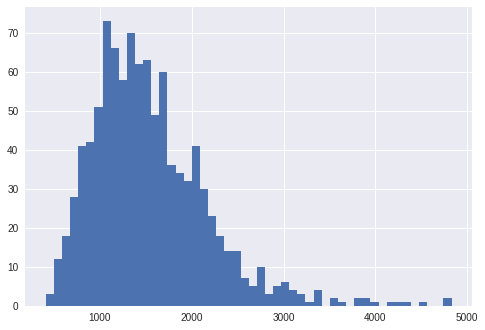

In [10]:
plt.hist(result[0], bins=50)

(array([  2.,   2.,   5.,   9.,  12.,  17.,  19.,  23.,  34.,  46.,  50.,
         43.,  70.,  60.,  46.,  63.,  44.,  57.,  48.,  50.,  42.,  40.,
         34.,  29.,  23.,  15.,  22.,  17.,   7.,  13.,  10.,   6.,   4.,
         10.,   4.,   6.,   1.,   2.,   3.,   3.,   1.,   2.,   0.,   2.,
          1.,   1.,   0.,   1.,   0.,   1.]),
 array([ 17265.03648  ,  18380.2766862,  19495.5168924,  20610.7570986,
         21725.9973048,  22841.237511 ,  23956.4777172,  25071.7179234,
         26186.9581296,  27302.1983358,  28417.438542 ,  29532.6787482,
         30647.9189544,  31763.1591606,  32878.3993668,  33993.639573 ,
         35108.8797792,  36224.1199854,  37339.3601916,  38454.6003978,
         39569.840604 ,  40685.0808102,  41800.3210164,  42915.5612226,
         44030.8014288,  45146.041635 ,  46261.2818412,  47376.5220474,
         48491.7622536,  49607.0024598,  50722.242666 ,  51837.4828722,
         52952.7230784,  54067.9632846,  55183.2034908,  56298.443697 ,
         5

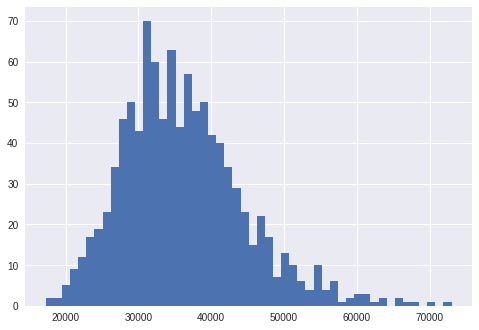

In [11]:
plt.hist(result_sum, bins=50)

In [13]:
pd.Series(result_sum).describe()

count     1000.000000
mean     36162.576867
std       8435.025116
min      17265.036480
25%      30346.218617
50%      35092.768705
75%      40819.250750
max      73027.046790
dtype: float64